### 5.5.1 Computing the gradient automatically
- PyTorch tensors can remember where they come from, in terms of the operations and parent tensors that originated them, and they can automatically provide the chain of derivatives of such operations with respect to their inputs.
    - This means we won't need to derive our model by hand; **given a forward expression, no matter how nested**, PyTorch will automatically provide the gradient of that expression with respect to its input parameters.

In [8]:
import torch
from PIL import Image

In [6]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [2]:
# 以前利用したmodel, loss_fn:
def model(t_u, w, b):
    return w * t_u + b

In [3]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

- Again initialize a parameters tensor:

In [4]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

- `requires_grad=True` is telling PyTorch to track the entire family tree of tensors resulting from operations on `params`.
- In other words, any tensor that will have `params` as an ancestor will have access to the chain of functions that were called to get from `params` to that tensor.
- In case these functions are differentiable, the value of the derivative will be automatically populated as a **`grad` attribute of the `params` tensor**. 分かっていないこと：`params`の後継が沢山ある場合はどうなる？でも`backward()`をcallするのは`loss`だから、`loss`の微分を保存するのが分かるでしょう。
- In general, all PyTorch tensors have an attribute named `grad`. Normally, it's `None`:

In [5]:
params.grad is None

True

- All we have to do to populate it is to **start with a tensor with `requires_grad` set to `True`**, then **call the model and compute the loss**, and then **call `backward` on the `loss` tensor**:

In [7]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

- At this point, the `grad` attribute of `params` contains the derivatives of the loss with respect to each element of params.
- When we compute our `loss` while the parameters `w` and `b` require gradients, in addition to performing the actual computation, PyTorch creates the **autograd graph with the operations as nodes**:

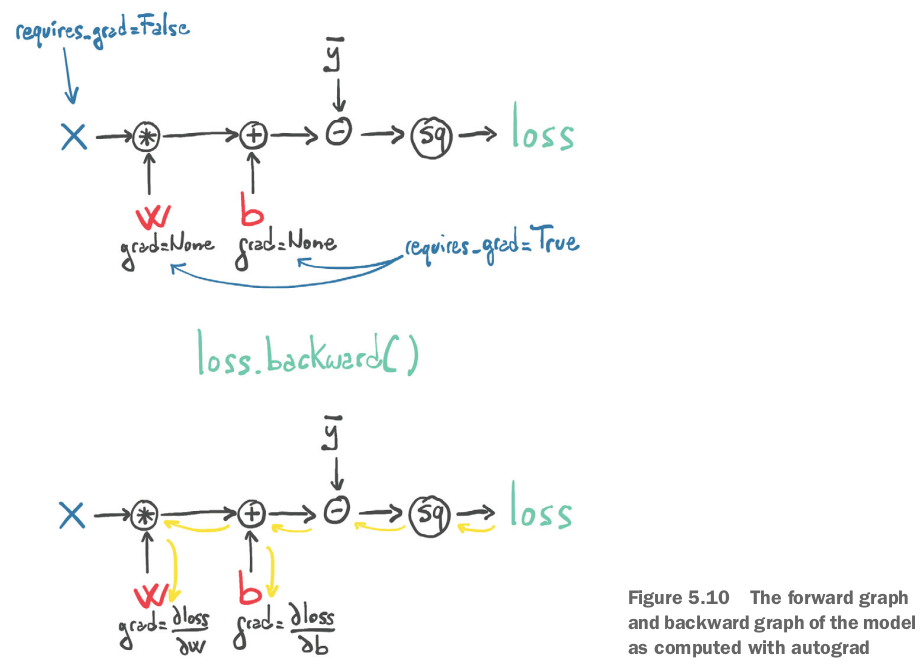

In [9]:
Image.open('img/forward-graph-backward-graph-2020-12-20-13-27-08.png')

- 注意：Calling `backward` will lead derivatives to **accumulate** at leaf nodes.
- So if `backward` was called earlier, the loss is evaluated again, `backward` is called again (as in any training loop), and the gradient at each leaf is **accumulated (that is, summed) on top of the one computed at the previous iteration**, which leads to **an incorrect value for the gradient**.
- In order to prevent this from occurring, we need to ***zero the gradient explicitly* at each iteration**.
    - We can do this easily using the in-place `zero_` method:

In [10]:
if params.grad is not None:
    params.grad.zero_()

- なぜdefaultでaccumulateじゃなくて、saveしないの？：Doing it this way provides more flexibility and control when working with gradients in complicated models.

In [11]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None: # This could be done at any point in the loop prior to calling loss.backward()
            params.grad.zero_()
        
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():
            params -= learning_rate * params.grad
        
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    
    return params

- We are encapsulating the update **in a `no_grad` context using the Python `with` statement**. 
    - This means within the `with` block, the PyTorch autograd mechanism should look away: that is, **not add edges to the forward graph**.
- We update `params` in place.
    - When using autograd, we **usually avoid in-place updates** because PyTorch's autograd engine **might need the values we would be modifying for the backward pass**.
    - Here, however, we are operating without autograd, and it is beneficial to keep the `params` tensor.
    - **Not replacing the parameters by assigning new tensors to their variable name will become crucial when we register our parameters with the optimizer**.

In [13]:
t_un = 0.1 * t_u

In [15]:
training_loop(n_epochs=5000,
             learning_rate=1e-2,
             params=torch.tensor([1.0, 0.0], requires_grad=True),
             t_u=t_un,
             t_c=t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

### 5.5.2 Optimizers a la carte (アラカルトとは、献立「こんだて」表から好みに応じて一品ずつ注文する料理のこと)

In [16]:
import torch.optim as optim

In [17]:
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_multi_tensor',
 'functional',
 'lr_scheduler',
 'swa_utils']

- Every optimizer constructor takes a list of parameters (aka PyTorch tensors, typically with `requires_grad` set to `True`) as the first input.
- All parameters passed to the optimizer are **retained inside the optimizer object** so the optimizer can update their values and access their `grad` attribute:

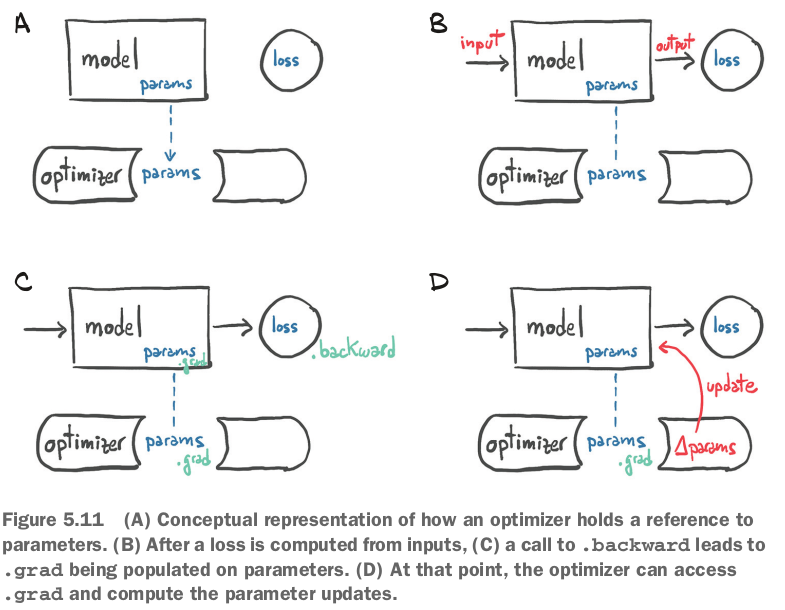

In [18]:
Image.open('img/optimizer-2020-12-20-17-23-32.png')

- Each optimizer exposes two methods: `zero_grad` and `step`.
    - `zero_grad` **zeroes the `grad` attribute** of all the parameters passed to the optimizer **upon construction**.
    - `step` updates the value of those parameters according to the optimization strategy implemented by the specific optimizer.
- create `params` and instantiate a gradient descent optimizer:

In [19]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

In [20]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step()

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

- **The value of `params` is updated upon calling `step` without us having to touch it ourselves!**
- training loopに使うには、またbackward()の前にgradientをクリアしないといけない：

In [21]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad()
loss.backward()
optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

- Update our training loop accordingly:

In [22]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [23]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(n_epochs=5000,
             optimizer=optimizer,
             params=params,
             t_u=t_un,
             t_c=t_c)

Epoch 500, Loss 7.860120
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

- Adam: learning rate is set adaptively.
    - It is **a lot less sensitive to the scaling of the parameters** - so insensitive that we can go back to using the original (non-normalized) input `t_u`, and **even increase the learning rate to `1e-1`**, and Adam won't even blink:

In [24]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(n_epochs=2000,
             optimizer=optimizer,
             params=params,
             t_u=t_u,
             t_c=t_c)

Epoch 500, Loss 7.612900
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928579
Epoch 2000, Loss 2.927644


tensor([  0.5367, -17.3021], requires_grad=True)

- この例にmodel functionを勝手に設計したが、neural networks allow us to remove our arbitrary assumptions about the shape of the function we should be approximating.
- 上記例の要素：backpropagation to estimate gradients, autograd, and optimizing weights of models using gradient descent or other optimizers.

### 5.5.3 Training, validation, and overfitting

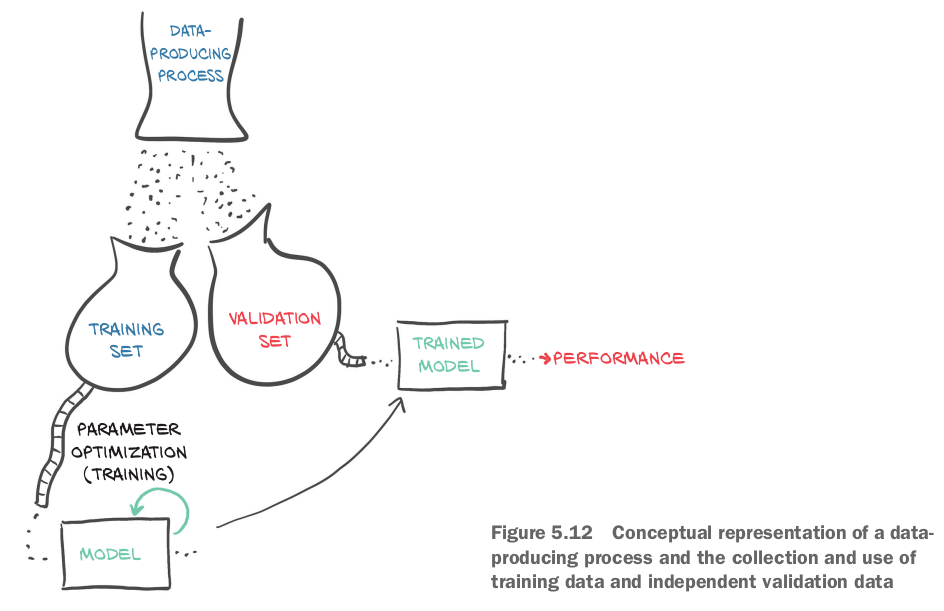

In [25]:
Image.open('img/training-and-validation-set-2020-12-20-17-58-14.png')

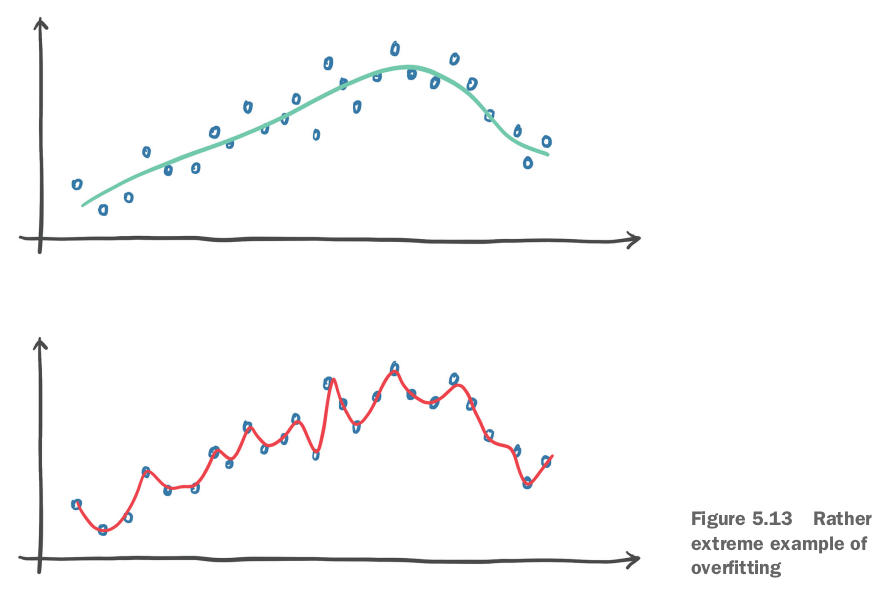

In [26]:
Image.open('img/overfitting-2020-12-20-18-49-55.png')

- Regularization策：
    - Adding *penalization terms* to the loss function, to make it cheaper for the model to behave more smoothly and change more slowly (**up to a point**).
    - Add noise to the input samples, to artificially create new data points in between training data samples and force the model to try to fit those, too.
    - But the best favor we can do to ourselves, at least as a first move, is to **make our model simpler**.
- Splitting a dataset:
    - Shuffle the elements of a tensor amounts to **finding a permutation of its indices**, `randperm` function:

In [27]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 1,  6,  9,  8, 10,  3,  0,  7,  2]), tensor([4, 5]))

In [28]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

- Additionally evaluate the validation loss at every epoch (to have a chance to recognize whether we're overfitting):

In [29]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 == 0:
            print(f'Epoch {epoch}, Training loss {train_loss.item():.4f},'
                 f' Validation loss {val_loss.item():.4f}')
            
    return params

In [30]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

# Since we're using SGD again, we're back to using normalized inputs.
training_loop(n_epochs=3000,
             optimizer=optimizer,
             params=params,
             train_t_u=train_t_un,
             val_t_u=val_t_un,
             train_t_c=train_t_c,
             val_t_c=val_t_c)

Epoch 1, Training loss 93.9443, Validation loss 19.2545
Epoch 2, Training loss 43.2299, Validation loss 0.7752
Epoch 3, Training loss 35.5362, Validation loss 4.8714
Epoch 500, Training loss 7.1039, Validation loss 5.2108
Epoch 1000, Training loss 3.5098, Validation loss 3.8908
Epoch 1500, Training loss 3.0399, Validation loss 3.5031
Epoch 2000, Training loss 2.9784, Validation loss 3.3746
Epoch 2500, Training loss 2.9704, Validation loss 3.3296
Epoch 3000, Training loss 2.9693, Validation loss 3.3136


tensor([  5.3838, -17.0660], requires_grad=True)

- The validation set is really small, so the validation loss will only be meaningful up to a point.

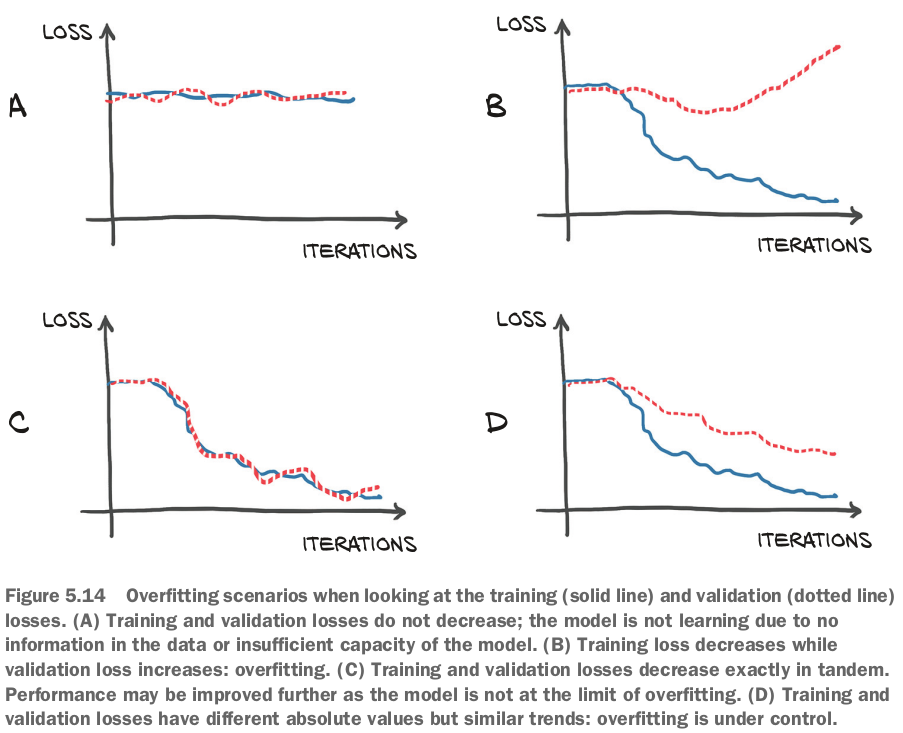

In [31]:
Image.open('img/looking-training-and-validation-losses-2020-12-20-19-20-57.png')

- Case C is ideal, while D is acceptable.

### 5.5.4 Autograd nits and switching it off

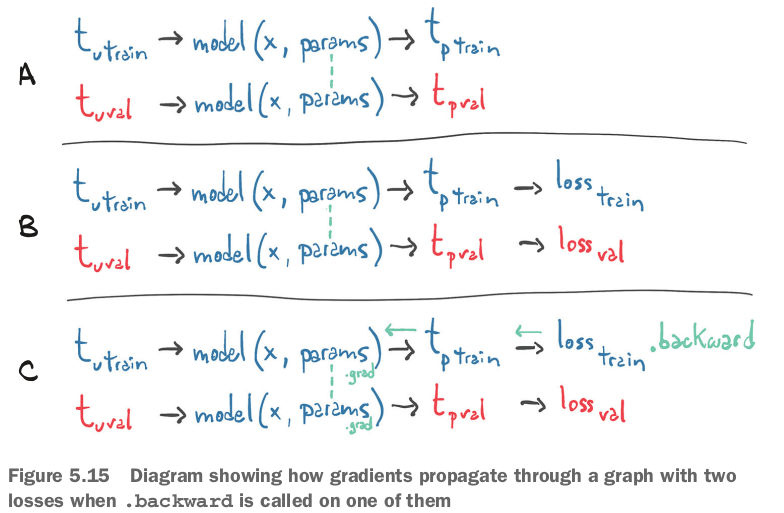

In [32]:
Image.open('img/two-computing-graph-and-one-backward-2020-12-20-19-52-43.png')

- 課題：Since we're not ever calling `backward` on `val_loss`, why are we building the graph in the first place?
    - In order to address this, PyTorch allows us to switch off autograd when we don't need it, using the `torch.no_grad` context manager.
- For larger models, the differences can add up.
- We can make sure this works by checking the value of the `requires_grad` attribute on the `val_loss` tensor: わかっていないこと：`val_loss`をチェックするんだ。

In [33]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

In [34]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

# Since we're using SGD again, we're back to using normalized inputs.
training_loop(n_epochs=3000,
             optimizer=optimizer,
             params=params,
             train_t_u=train_t_un,
             val_t_u=val_t_un,
             train_t_c=train_t_c,
             val_t_c=val_t_c)

- もう１つcontrol方法：`set_grad_enabled`

In [35]:
def calc_forward(t_u, t_c, is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss